In [1]:
%matplotlib inline
import torch
import tqdm
import torch.nn as nn
from d2l import torch as d2l

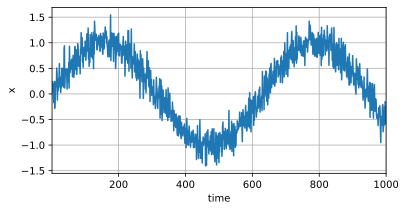

In [2]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
X = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T, )) # 综上所述，(T,) 和 (T, -1) 都表示一维张量，区别在于对于 (T, -1)，系统会根据其他维度自动计算该维度的大小。
d2l.plot(time, [X], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [3]:
tau = 4
features = torch.zeros(T - tau, tau)
for i in range(tau):
    features[:, i] = X[i: T - tau + i]
labels = X[tau:].reshape(-1, 1)

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[: n_train], labels[: n_train]), batch_size, is_train=True)

In [4]:
def init_weight(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight) 

def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weight)
    return net

loss = nn.MSELoss(reduction='none')

In [5]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

In [6]:
net = get_net()
train(net, train_iter, loss, 10, 0.01)

epoch 1, loss: 0.056275
epoch 2, loss: 0.049737
epoch 3, loss: 0.049516
epoch 4, loss: 0.049448
epoch 5, loss: 0.048946
epoch 6, loss: 0.048468
epoch 7, loss: 0.047777
epoch 8, loss: 0.047624
epoch 9, loss: 0.049080
epoch 10, loss: 0.048601


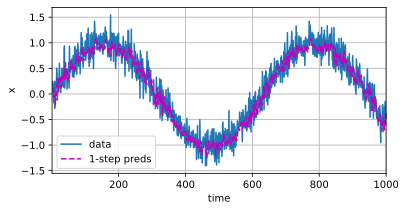

In [7]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [X.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

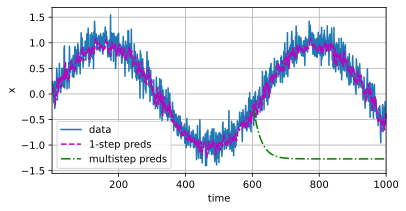

In [8]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = X[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))
    
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [X.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

In [9]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = X[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

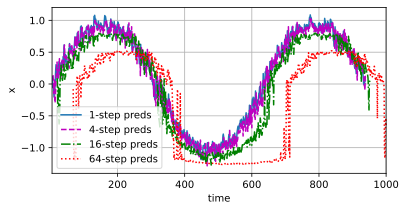

In [10]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))